<a href="https://colab.research.google.com/github/rizavelioglu/hateful_memes-hate_detectron/blob/main/notebooks/%5BGitHub%5Dsimple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is originally prepared by DrivenData ([see original post](https://www.drivendata.co/blog/hateful-memes-benchmark/)). 

I have applied minor changes to the code such that it is executable on Colab.

# <font color='magenta'> <b> Imports </b> </font>

We will use a torchvision vision model to extract features from meme images and a fasttext model to extract features from extracted text belonging to images. These language and vision features will be fused together using torch to form a multimodal hateful memes classifer. Let's go ahead and import them now.



### Install PyTorch Lightning

In [1]:
# !pip install pytorch-lightning
!pip install pytorch_lightning==0.6.0 torch==1.3.1

     |████████████████████████████████| 102kB 4.1MB/s 
     |████████████████████████████████| 734.6MB 26kB/s 
     |████████████████████████████████| 10.2MB 20.5MB/s 
     |████████████████████████████████| 829kB 35.9MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.6.0-cp37-none-any.whl size=116150 sha256=3888b12acc16137373fb958a4c4729b1311cb080ad7b4be633b49933f66e9c18
  Stored in directory: /root/.cache/pip/wheels/53/08/72/257c395e632f8e4d68770e3935e1ba489e8a7cc82b2fd8d241
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=dd6243dd18a1a3d485f667f48f9c8dd17b11931c052b1608719d9596379acae2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built pytorch-lightning future
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
  

### Install fastText

In [2]:
!pip install fasttext

     |████████████████████████████████| 71kB 3.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094260 sha256=846b02aa05bc7f2927a618e0cc6a2a5db13d8c097bf0f64b4a2be7e67a5b5c19
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


### Import libraries

In [3]:
%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pandas_path  # Path style access for pandas
from tqdm import tqdm

import torch                    
import torchvision
import fasttext

---
# <font color='magenta'> <b> Loading the Data </b> </font>

---
## Download & Unzip

In [15]:
#@markdown ---
#@title <h1><b><font color='red'> --Action required!-- </b></font></h1> { run: "auto" }
#@markdown First, please specify the download link and the `.zip` password which both can be taken from [DrivenData](https://www.drivendata.org/competitions/70/hateful-memes-phase-2/data/)


YOUR_LINK_TO_DOWNLOAD_PHASE2_DATA = '' #@param {type:"string"}
PASSWORD_OF_ZIP = '' #@param {type:"string"}

In [ ]:
!wget -O XjiOc5ycDBRRNwbhRlgH.zip --no-check-certificate --no-proxy "$YOUR_LINK_TO_DOWNLOAD_PHASE2_DATA"

In [ ]:
# Unzips the zip quietly with the help of the "-qq" argument
!unzip -qq -P "$PASSWORD_OF_ZIP" XjiOc5ycDBRRNwbhRlgH.zip

In [ ]:
data_dir = Path.cwd().parent / "content" / "data"

img_tar_path = data_dir / "img"
train_path = data_dir / "train.jsonl"
dev_path = data_dir / "dev_seen.jsonl"
test_path = data_dir / "test_seen.jsonl"

In [ ]:
train_samples_frame = pd.read_json(train_path, lines=True)
train_samples_frame.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
train_samples_frame.label.value_counts()

0    5481
1    3019
Name: label, dtype: int64

---
## Exploring the Text Data

In [ ]:
train_samples_frame.text.map(
    lambda text: len(text.split(" "))
).describe()

count    8500.000000
mean       11.748706
std         6.877880
min         1.000000
25%         7.000000
50%        10.000000
75%        15.000000
max        70.000000
Name: text, dtype: float64

As we may have expected, the meme text isn't usually too long.

---
##  Exploring the Image Data

In [ ]:
from PIL import Image


images = [
    Image.open(
        data_dir / train_samples_frame.loc[i, "img"]
    ).convert("RGB")
    for i in range(5)
]

for image in images:
    print(image.size)

(265, 400)
(800, 533)
(558, 800)
(693, 800)
(550, 416)


It looks like we'll need to resize the images to form tensor minibatches appropriate for training a model. 

This is where we turn to the `torchvision.transforms` module. We can use its `Compose` object to perform a series of transformations. 

For example, here we'll `Resize` the images (this function interpolates when needed so may distort images) then convert them to PyTorch tensors using `ToTensor`. Once the images are a uniform same size, we can make a single tensor object out of them with `torch.stack` and use the `torchvision.utils.make_grid` function to easily visualize them in Matplotlib.

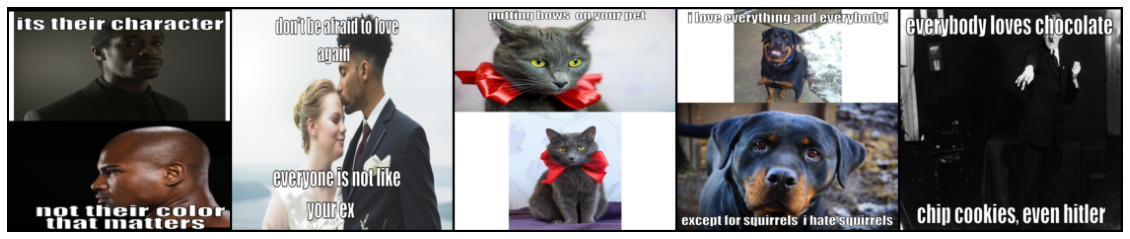

In [ ]:
# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

# plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

---
# <font color='magenta'> <b> Building a Multimodal Model </b> </font>

>Now that we have a sense of how we're going to need to process the data, we can start the model building process. There are three big-picture considerations to keep in mind as we develop the model,

- Dataset handling
- Model architecture
- Training logic

---
## Creating a Multimodal Dataset

> Our model will need to process appropriately transformed images and properly encoded text inputs separately. That means for each sample from our dataset, we'll need to be able to access "image" and "text" data independently. Lucky for us, the PyTorch Dataset class makes this pretty easy. If you haven't yet had the pleasure of working with this object, we highly reccomend the short [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

> All we're required to do to subclass a Dataset is

- Define its size by overriding `__len__`
- Define how it returns a sample by overriding `__getitem__`

> We can use the Pandas DataFrame of json records as we did above with `train_samples_frame` to do both of these things and more. We can get the length of the dataset from the samples frame, use the *`img`* column to load the images, subsample our data for faster development using the Pandas sample method, and balance the training set by slicing the dataframe based on label—we can even use DrivenData's own pandas_path accessor to help validate the data!

> We want the dataset to return data ready for model input, that means `torch.tensors`. So our `__getitem__` method will need to prepare

- Images by applying *`image_transform`*
- Text by applying *`text_transform`*

> *`image_transform`* was introduced above, and *`text_transform`* will be the "sentence vector" created by our fastText model.

We'll return our samples as dictionaries with keys for

- "id", the image id
- "image", the image tensor
- "text", the text tensor
- "label", the label if it exists

In [ ]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):

        self.samples_frame = pd.read_json(data_path, lines=True)
        self.dev_limit = dev_limit
        if balance:
            neg = self.samples_frame[self.samples_frame.label.eq(0)]
            pos = self.samples_frame[self.samples_frame.label.eq(1)]
            
            self.samples_frame = pd.concat([neg.sample(pos.shape[0], random_state=random_state),
                                            pos])

        if self.dev_limit:
            if self.samples_frame.shape[0] > self.dev_limit:
                self.samples_frame = self.samples_frame.sample(
                    dev_limit, random_state=random_state
                )
        self.samples_frame = self.samples_frame.reset_index(drop=True)
        
        self.samples_frame.img = self.samples_frame.apply(
            lambda row: (img_dir / row.img), axis=1
        )

        # https://github.com/drivendataorg/pandas-path
        # if not self.samples_frame.img.path.exists().all():
        #     raise FileNotFoundError
        # if not self.samples_frame.img.path.is_file().all():
        #     raise TypeError
            
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]

        image = Image.open(
            self.samples_frame.loc[idx, "img"]
        ).convert("RGB")
        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, "text"]
            )
        ).squeeze()

        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "label"]]
            ).long().squeeze()
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "label": label
            }
        else:
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text
            }

        return sample

---
## Creating a Multimodal Model

If you're new to PyTorch, check out their [guide](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html) to creating custom modules. We're going to implement a design called mid-level concat fusion.

![model](https://drivendata-public-assets.s3.amazonaws.com/mid-level.png)

In [ ]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,
        
    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim), 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image, label=None):
        text_features = torch.nn.functional.relu(
            self.language_module(text)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

---
# <font color='magenta'> <b> Training a Multimodal Model </b> </font>

---
## Define the model

By subclassing the PyTorch Lightning `LightningModule`, we get most of the training logic "for free" behind the scenes. We just have to define what a <font color='cyan'>`forward`</font> call and <font color='cyan'>`training_step`</font> are, and provide our model with a `train_dataloader`

Behavior such as checkpoint saving and early stopping can be parameterized, but need not be fully implemented because Lightning handles the details. We can also add any additional methods we want, e.g., <font color='cyan'>`make_submission_frame`</font> for preparing our competition submission csv. If you're new to PyTorch Lightning, you may fine their [quick start guide](https://pytorch-lightning.readthedocs.io/en/latest/new-project.html) useful.

> We're going to implement a `LightningModule` subclass called <font color='greenyellow'>`HatefulMemesModel`</font> which takes a Python `dict` of hyperparameters called `hparams` that are used to customize the instantiation. This pattern is a Lightning convention that allows us to easily load trained models for future use, as we'll see when we generate a submission to the competition.

For the language and vision module definitions, see the <font color='cyan'>`_build_model`</font> method. 

- The language module is going to use `fasttext` embeddings as input, computed as the `text_transform` in our data generator (we'll keep the embeddings fixed for simplicity, although they are fit to our training data). The outputs of the language module will come from a trainable `Linear` layer, as a way of fine-tuning the embedding representation during training. 
- The vision module inputs will be normalized images, computed as the `image_transform` in our data generator, and the outputs will be the outputs of a ResNet model.

Note: We'll also add defaults for almost all of the `hparams` referenced in our <font color='greenyellow'>`HatefulMemesModel`</font>. This will make it easier to focus on the changes you want to make while experimenting rather than needing to include a bunch a defaults. These could be included as defaults, but Lightning is easiest to use when we keep them factored into `hparams`. This is reasonable, since everything specified by `hparams` is independend of the actual modeling architecture we defined above.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM


# for the purposes of this post, we'll filter
# much of the lovely logging info from our LightningModule
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


class HatefulMemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        
        super(HatefulMemesModel, self).__init__()
        self.hparams = hparams
        
        # assign some hparams that get used in multiple places
        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get("language_feature_dim", 300)
        # balance language and vision features by default
        self.vision_feature_dim = self.hparams.get("vision_feature_dim", self.language_feature_dim)
        self.output_path = Path(self.hparams.get("output_path", "model-outputs"))
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        self.text_transform = self._build_text_transform()
        self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset("train_path")
        self.dev_dataset = self._build_dataset("dev_path")
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, text, image, label=None):
        return self.model(text, image, label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )

        acc = FM.accuracy(preds, batch["label"], num_classes=2)
        
        return {"batch_val_loss": loss, "batch_val_acc": acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        
        avg_acc = torch.stack(
            tuple(
                output["batch_val_acc"] 
                for output in outputs
            )
        ).mean()

        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss, "avg_val_acc": avg_acc}
        }

    def configure_optimizers(self):
        optimizers = [
            torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.001)
            )
        ]
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[0]
            )
        ]
        return optimizers, schedulers
    
    # @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )

    # @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.dev_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )
    
    ## Convenience Methods ##
    
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _build_text_transform(self):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:
                training_data = [
                    json.loads(line)["text"] + "/n" 
                    for line in open(
                        self.hparams.get("train_path")
                    ).read().splitlines()
                ]
                for line in training_data:
                    ft.write(line + "\n")
                language_transform = fasttext.train_unsupervised(
                    str(ft_path),
                    model=self.hparams.get("fasttext_model", "cbow"),
                    dim=self.embedding_dim
                )
        return language_transform
    
    def _build_image_transform(self):
        image_dim = self.hparams.get("image_dim", 224)
        image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return image_transform

    def _build_dataset(self, dataset_key):
        return HatefulMemesDataset(
            data_path=self.hparams.get(dataset_key, dataset_key),
            img_dir=self.hparams.get("img_dir"),
            image_transform=self.image_transform,
            text_transform=self.text_transform,
            # limit training samples only
            dev_limit=(
                self.hparams.get("dev_limit", None) 
                if "train" in str(dataset_key) else None
            ),
            balance=True if "train" in str(dataset_key) else False,
        )
    
    def _build_model(self):
        # we're going to pass the outputs of our text
        # transform through an additional trainable layer
        # rather than fine-tuning the transform
        language_module = torch.nn.Linear(
                in_features=self.embedding_dim,
                out_features=self.language_feature_dim
        )
        
        # easiest way to get features rather than
        # classification is to overwrite last layer
        # with an identity transformation, we'll reduce
        # dimension using a Linear layer, resnet is 2048 out
        vision_module = torchvision.models.resnet152(
            pretrained=True
        )
        vision_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.vision_feature_dim
        )

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            language_module=language_module,
            vision_module=vision_module,
            language_feature_dim=self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            filepath=self.output_path,
            monitor=self.hparams.get(
                "checkpoint_monitor", "avg_val_acc"
            ),
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "max"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "avg_val_acc"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 5
            ),
            verbose=self.hparams.get("verbose", True),
        )

        trainer_params = {
            "checkpoint_callback": checkpoint_callback,
            "early_stop_callback": early_stop_callback,
            # "default_save_path": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params
            
    @torch.no_grad()
    def make_submission_frame(self, test_path):
        test_dataset = self._build_dataset(test_path)
        submission_frame = pd.DataFrame(
            index=test_dataset.samples_frame.id,
            columns=["proba", "label"]
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16))
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(
                batch["text"], batch["image"]
            )
            submission_frame.loc[batch["id"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["id"], "label"] = preds.argmax(dim=1)
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.label.astype(int)
        return submission_frame

Let's recap what we've done. We've separated our data processing, modeling, and training logic:
- Data processing code is contained inside of <font color='greenyellow'>`HatefulMemesDataset`</font>, which subclasses PyTorch `Dataset`
- Multimodal fusion model code is contained inside of <font color='greenyellow'>`LanguageAndVisionConcat`</font>, which subclasses PyTorch `torch.nn.Module`
- Training, early stopping, checkpoint saving, and submission building code is contained inside of <font color='greenyellow'>`HatefulMemesModel`</font>, which subclasses the PyTorch Lightning `pl.LightningModule`

> A <font color='greenyellow'>`HatefulMemesModel`</font> can be instantiated using only a `dict` of `hparams`. There are only a few required hparams—the paths which point to our `.jsonl` files as well as the image directory. Our `__init__` will tell us if we've forgotten those. Beyond that, there are many hyperparameters we could specifiy in order to experiment with different models and early stopping strategies, batch sizes, learning rates, ..., but thanks to the handy `.get` method on Python dictionaries, our code won't fail us if we fail to specify these parameters.

---
## Fit the Model

In [ ]:
hparams = {
    
    # Required hparams
    "train_path": train_path,
    "dev_path": dev_path,
    "img_dir": data_dir,
    
    # Optional hparams
    "embedding_dim": 150,
    "language_feature_dim": 300,
    "vision_feature_dim": 300,
    "fusion_output_size": 256,
    "output_path": "model-outputs",
    "dev_limit": None,
    "lr": 0.0005,
    "max_epochs": 10,
    "n_gpu": 1,
    "batch_size": 4,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
    "early_stop_patience": 3,
}

hateful_memes_model = HatefulMemesModel(hparams=hparams)
hateful_memes_model.fit()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

---
# <font color='magenta'> <b> Making a submission </b> </font>

In [ ]:
# we should only have saved the best checkpoint
checkpoints = list(Path("model-outputs").glob("*.ckpt"))
assert len(checkpoints) == 1

checkpoints

In [ ]:
hateful_memes_model = HatefulMemesModel.load_from_checkpoint(
    checkpoints[0]
)
submission = hateful_memes_model.make_submission_frame(
    test_path
)
submission.head()

In [ ]:
# Since this is a first pass, let's check a couple of things.
submission.groupby("label").proba.mean()

In [ ]:
submission.label.value_counts()

In [ ]:
submission.to_csv(("model-outputs/submission.csv"), index=True)